<a href="https://colab.research.google.com/github/kwarrenw/PytorchCode/blob/main/KarlWilson_Module3_MNIST_Adversarial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Train a AI model as our target.


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets
from torch.utils.data import Subset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# This function is used to display a batch of images.
def show_images(images) -> None:
    # Get the number of images in the batch.
    n: int = images.size(0)

    # Create a figure to display the images.
    f = plt.figure(figsize=(24, 6))
    # Loop through each image in the batch.
    for i in range(n):
        # Add a subplot for the current image.
        f.add_subplot(1, n, i + 1)
        # Display the image in grayscale.
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        # Turn off the axis labels.
        plt.axis('off')

    # Show the plot.
    plt.show(block=True)

# This function is used to display a batch of images along with their true labels and predicted labels.
def show_images_withPred(images,label,pred) -> None:
    # Get the number of images in the batch.
    n: int = images.size(0)

    # Create a figure to display the images.
    f = plt.figure(figsize=(24, 6))
    # Loop through each image in the batch.
    for i in range(n):
        # Add a subplot for the current image.
        f.add_subplot(1, n, i + 1)
        # Display the image in grayscale.
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        # Set the title to show the true label and the predicted label.
        plt.title("{} -> {}".format(label[i], pred[i]))
        #plt.title("Conf:{} \n {} -> {}".format(conf[i][pred[i]]*100,label[i], pred[i]))
        # Turn off the axis labels.
        plt.axis('off')

    # Show the plot.
    plt.show(block=True)

# Hyperparameters are settings that control the training process.
num_epochs = 10 # Number of times to loop through the entire dataset.
num_classes = 10 # Number of output classes (0-9 for MNIST).
batch_size = 256 # Number of images to process in each training step.
learning_rate = 0.001 # How much to adjust the model's weights in each step.


DATA_PATH = 'data/' # Directory to store the dataset.
MODEL_STORE_PATH = 'models/' # Directory to save trained models.

# Transforms are operations applied to the data before feeding it to the model.
# transforms.Compose chains multiple transforms together.
# transforms.ToTensor() converts images to PyTorch tensors.
trans = transforms.Compose([transforms.ToTensor()])

# Load the MNIST dataset. MNIST is a dataset of handwritten digits.
# root: Specifies the directory where the data will be stored.
# train=True: Loads the training dataset.
# transform: Applies the defined transformations to the images.
# download=True: Downloads the dataset if it's not already present.
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True)
# Load the test dataset.
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

# Data loaders are used to efficiently load data in batches during training and testing.
# dataset: The dataset to load data from.
# batch_size: The number of samples per batch.
# num_workers: How many subprocesses to use for data loading.
# shuffle=True: Shuffles the data in the training set for better training.
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
# shuffle=False: No need to shuffle the test set.
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)

# Define the Convolutional Neural Network (CNN) model. This is a LeNet-like architecture.
class LeNet(nn.Module):
    def __init__(self):
        # Call the constructor of the parent class (nn.Module).
        super(LeNet, self).__init__()
        # Define the layers for extracting features from the images.
        self.features = nn.Sequential(
            # Convolutional layer 1: Applies filters to the image to detect features.
            # 1 input channel (grayscale image), 8 output channels (filters).
            # kernel_size=5: Size of the filter.
            # stride=1: How many pixels to move the filter at a time.
            # padding=2: Adds padding to the image borders to preserve spatial dimensions.
            nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=2),
            nn.ReLU(), # ReLU activation function: Introduces non-linearity.
            nn.BatchNorm2d(8), # Batch normalization: Helps stabilize training.
            nn.MaxPool2d(kernel_size=2, stride=2), # Max pooling layer 1: Reduces the spatial dimensions.
            # Convolutional layer 2: Applies more filters to the features from the previous layer.
            # 8 input channels, 16 output channels.
            nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(), # ReLU activation function.
            nn.BatchNorm2d(16), # Batch normalization.
            nn.MaxPool2d(kernel_size=2, stride=2), # Max pooling layer 2.
            nn.Flatten(1, -1), # Flatten the output into a 1D tensor to feed into the fully connected layers.
            # Fully connected layer 1: A standard neural network layer.
            # Takes the flattened features as input and outputs 120 neurons.
            nn.Linear(7 * 7 * 16, 120),
            nn.ReLU(), # ReLU activation function.
            nn.Linear(120, 84), # Fully connected layer 2: Outputs 84 neurons.
            nn.ReLU(), # ReLU activation function.
        )
        # Output layer: Maps the features to the final number of classes (10 for digits 0-9).
        self.fc3 = nn.Linear(84, 10)

    # Define the forward pass: How data flows through the network.
    def forward(self, x):
        # Pass the input image through the feature extraction layers.
        out = self.features(x)
        # Pass the output of the feature layers through the final classification layer.
        out = self.fc3(out)

        return out

# Create an instance of our LeNet model.
model=LeNet()
# Move the model to the GPU for faster training if a GPU is available.
model.cuda()
# Set the model to training mode. This enables layers like Dropout and BatchNorm to behave correctly during training.
model.train()

# Define the loss function and the optimizer.
criterion = nn.CrossEntropyLoss() # Cross-entropy loss is commonly used for classification tasks.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Adam optimizer is an efficient optimization algorithm.

# Set the model to training mode again (redundant here but good practice).
model.train()
# Lists to store loss and accuracy values during training for plotting later (optional).
loss_list_cnn = []
acc_list_cnn = []
# Calculate the total number of steps (batches) in one epoch.
total_step = len(train_loader)

# Start the training loop.
for epoch in range(num_epochs):
  # Iterate through each batch of images and labels in the training data.
  for i, (images, labels) in enumerate(train_loader):
    # Move the images and labels to the GPU.
    images = images.cuda()
    labels = labels.cuda()

    # Forward pass: Get predictions from the model.
    outputs = model(images)

    # Calculate the loss: How far off the predictions are from the true labels.
    loss = criterion(outputs, labels)
    # Store the loss value.
    loss_list_cnn.append(loss.item())

    # Backprop and perform Adam optimisation
    # Zero the gradients: Clear the gradients from the previous step.
    optimizer.zero_grad()
    # Backpropagation: Calculate the gradients of the loss with respect to the model's parameters.
    loss.backward()
    # Optimizer step: Update the model's parameters based on the calculated gradients.
    optimizer.step()

    # Track the accuracy
    # Get the total number of samples in the current batch.
    total = labels.size(0)
    # Get the predicted class for each image (the class with the highest probability).
    _, predicted = torch.max(outputs.data, 1)
    # Count the number of correct predictions in the current batch.
    correct = (predicted == labels).sum().item()
    # Store the accuracy value.
    acc_list_cnn.append(correct / total)

    # Print training progress every 150 steps.
    if (i%150 == 0):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, i, total_step, loss.item(),
                      (correct / total) * 100))


# Evaluation phase: Test the trained model on the unseen test data.
model.eval() # Set the model to evaluation mode. This disables features like Dropout.
with torch.no_grad(): # Disable gradient calculation during evaluation to save memory and speed up computation.
  correct = 0
  total = 0
  # Iterate through each batch in the test data.
  for images, labels in test_loader:
      # Move images and labels to the GPU.
      images = images.cuda()
      labels = labels.cuda()

      # Forward pass: Get predictions from the model.
      outputs = model(images)
      # Get the predicted class for each image.
      _, predicted = torch.max(outputs.data, 1)
      # Update the total number of samples.
      total += labels.size(0)
      # Update the number of correct predictions.
      correct += (predicted == labels).sum().item()

# Print the final accuracy of the model on the test dataset.
print(
  'Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.46MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.23MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.3MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/10], Step [0/235], Loss: 2.3130, Accuracy: 6.64%
Epoch [1/10], Step [150/235], Loss: 0.0701, Accuracy: 97.27%
Epoch [2/10], Step [0/235], Loss: 0.0716, Accuracy: 97.66%
Epoch [2/10], Step [150/235], Loss: 0.0415, Accuracy: 99.22%
Epoch [3/10], Step [0/235], Loss: 0.0451, Accuracy: 98.83%
Epoch [3/10], Step [150/235], Loss: 0.0181, Accuracy: 99.61%
Epoch [4/10], Step [0/235], Loss: 0.0451, Accuracy: 98.44%
Epoch [4/10], Step [150/235], Loss: 0.0269, Accuracy: 98.83%
Epoch [5/10], Step [0/235], Loss: 0.0329, Accuracy: 98.44%
Epoch [5/10], Step [150/235], Loss: 0.0317, Accuracy: 98.83%
Epoch [6/10], Step [0/235], Loss: 0.0105, Accuracy: 99.61%
Epoch [6/10], Step [150/235], Loss: 0.0134, Accuracy: 99.61%
Epoch [7/10], Step [0/235], Loss: 0.0166, Accuracy: 99.61%
Epoch [7/10], Step [150/235], Loss: 0.0124, Accuracy: 99.22%
Epoch [8/10], Step [0/235], Loss: 0.0034, Accuracy: 100.00%
Epoch [8/10], Step [150/235], Loss: 0.0153, Accuracy: 98.83%
Epoch [9/10], Step [0/235], Loss: 0.0108

The following is a Fast Gradient Sign Method (FGSM)

Accuracy of the model on the 10000 test images: 37.4 %


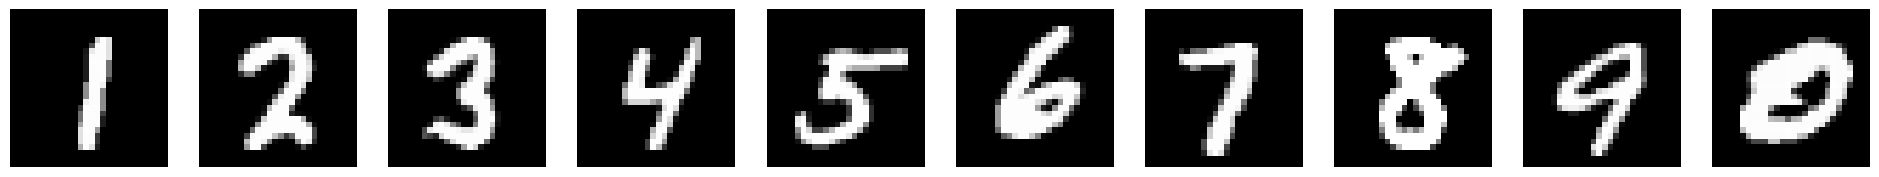

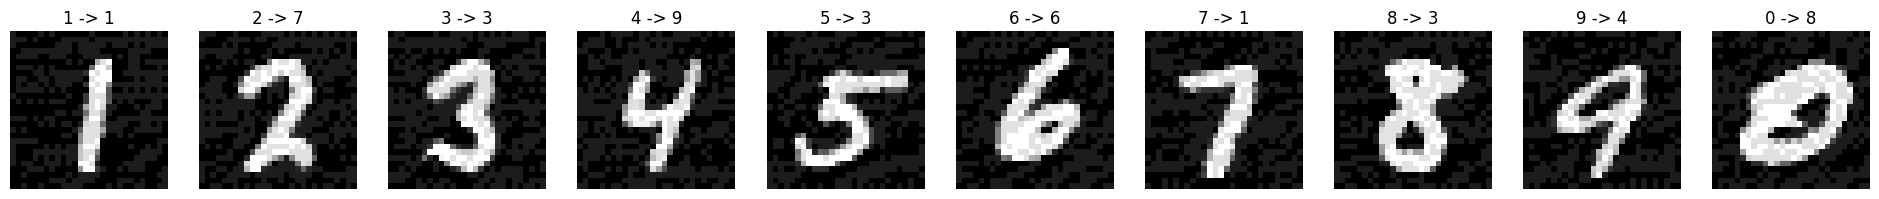

In [10]:
# This cell demonstrates the Fast Gradient Sign Method (FGSM), a simple and fast way to create adversarial examples.
# Adversarial examples are inputs (like images) that are slightly modified to fool a machine learning model, even though the changes are often imperceptible to humans.

# FGSM Attack function
# model: The trained neural network model we want to attack.
# criterion: The loss function used during training (e.g., CrossEntropyLoss).
# images: The original images we want to create adversarial examples from.
# labels: The true labels for the original images.
# step_size: A small value that controls how much noise is added to the image. A larger step size creates a stronger attack but might make the perturbation more visible.
def fgsm(model, criterion, images, labels, step_size) :

    # We need to calculate the gradients of the loss with respect to the input images.
    # Setting requires_grad = True tells PyTorch to keep track of these gradients.
    images.requires_grad = True # give me those gradients!

    # Feed the original images to the model to get the model's initial predictions.
    outputs = model(images)

    # Zero out any previously calculated gradients. This is important before calculating new gradients.
    model.zero_grad() #zero out the gradients
    # Compute the loss value using the model's outputs and the true labels.
    loss = criterion(outputs, labels) # compute loss value
    # Backpropagate the loss to calculate the gradients of the loss with respect to the input images.
    loss.backward() # feedback to the model, compute the gradients.

    # Now, we create the adversarial images.
    # The core idea of FGSM is to add a small perturbation to the original image in the direction that increases the loss the most.
    # This direction is given by the sign of the gradient of the loss with respect to the input image.
    # images.grad.sign(): Gets the sign of each element in the gradient tensor (+1 for positive, -1 for negative, 0 for zero).
    # step_size * images.grad.sign(): Scales the direction by the step size.
    # images + ... : Adds this scaled perturbation to the original images.
    ae_images = images + step_size*images.grad.sign()

    # Clamp the resulting adversarial images to be within the valid pixel range (usually 0 to 1 for normalized images).
    # This ensures the adversarial images are still valid images.
    ae_images = torch.clamp(ae_images, 0, 1)

    # Return the generated adversarial images.
    return ae_images

# Set the model to evaluation mode. This disables features like Dropout and uses learned statistics for BatchNorm, important for consistent evaluation.
model.eval()

# Initialize counters for tracking correct predictions on adversarial examples.
correct = 0
total = 0
# Iterate through each batch of images and labels in the test data loader.
for images, labels in test_loader:
    # Move the images and labels to the GPU if available for faster processing.
    images = images.cuda()
    labels = labels.cuda()
    # Generate adversarial examples using the FGSM function.
    # We use a step_size of 0.15, which is a hyperparameter that can be tuned.
    ae_images = fgsm(model, criterion, images, labels, step_size=0.112)

    # Now, test the trained model (model) on the generated adversarial images (ae_images).
    outputs = model(ae_images)
    # Get the predicted class for each adversarial image.
    # torch.max returns the maximum value and its index. We only need the index (the predicted class).
    _, predicted = torch.max(outputs.data, 1)
    # Update the total count of images processed.
    total += labels.size(0)
    # Update the count of correctly classified adversarial examples.
    # (predicted == labels): checks if the model's prediction on the adversarial image matches the true label.
    # .sum().item(): counts the number of True values (correct predictions).
    correct += (predicted == labels).sum().item()

# Print the accuracy of the model when evaluated on the adversarial examples.
# A significantly lower accuracy compared to the original test accuracy indicates that the model is vulnerable to this attack.
print(
  'Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

# Display the first 10 original images in the last batch processed.
# .detach(): removes the tensor from the computation graph, so no gradients are tracked.
# .cpu(): moves the tensor to the CPU for Matplotlib.
show_images(images[:10].detach().cpu())
# The line below is commented out, but you could uncomment it to see the adversarial images themselves.
# show_images(ae_images[:10].detach().cpu())
# Display the first 10 adversarial images along with their true labels and the model's predictions on the adversarial images.
show_images_withPred(ae_images[:10].detach().cpu(),labels[:10].cpu(), outputs[:10].argmax(dim=1).cpu())

The following is a Projected Gradient Descent (PGD) adversarial attack

Accuracy of the model on the 10000 test images: 7.04 %


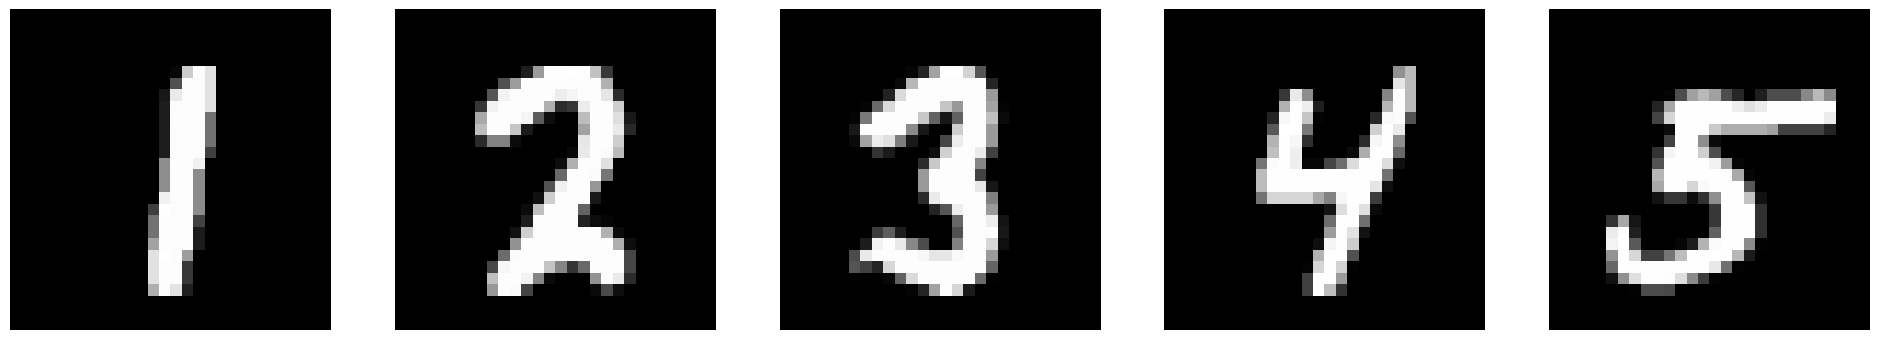

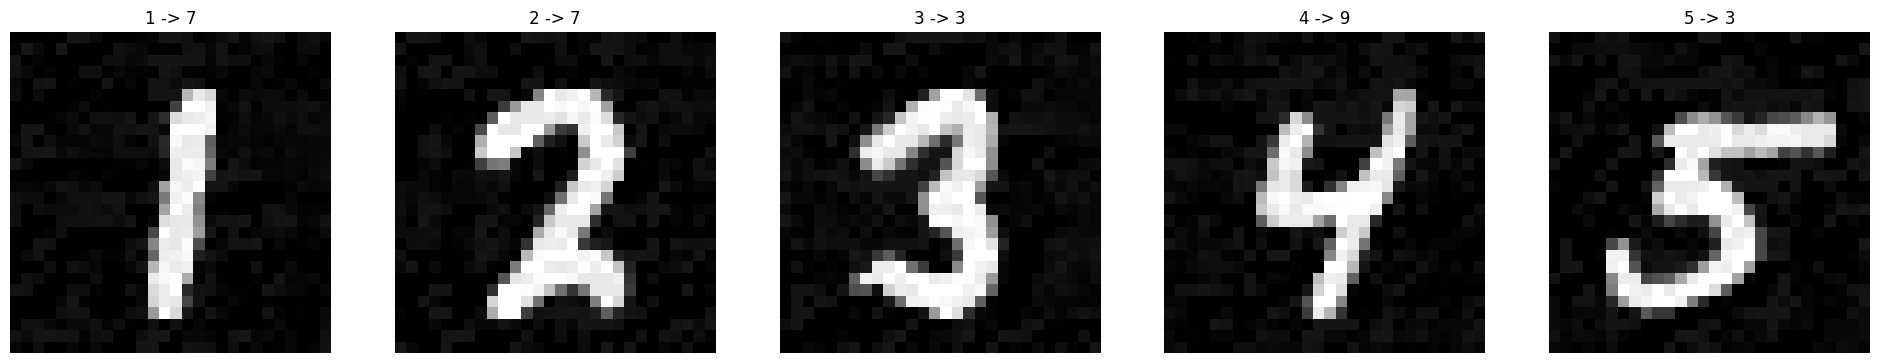

In [31]:
# This cell demonstrates the Projected Gradient Descent (PGD) adversarial attack.
# PGD is a more powerful attack than FGSM because it performs multiple smaller steps instead of one large step,
# and it projects the perturbed image back into a valid range after each step.

# PGD Attack function
# model: The trained neural network model to attack.
# images: The original images to generate adversarial examples from.
# criterion: The loss function.
# labels: The true labels for the original images.
# eps: The maximum allowed perturbation (how much the adversarial image can differ from the original). This is often called the epsilon budget.
# step_size: The size of each small step taken during the iterative process.
# iters: The number of steps (iterations) to perform. More iterations generally lead to a stronger attack but take longer.
def pgd_attack(model, images, criterion, labels, eps=0.25, step_size=0.0019, iters=45) :
    # Move images and labels to the GPU for faster computation.
    images = images.cuda()
    labels = labels.cuda()

    # Store the original images to ensure the final adversarial image is within a certain distance from the original.
    ori_images = images.data

    # Start the iterative process for PGD.
    for i in range(iters) :
        # We need to calculate gradients with respect to the image, so we require gradients.
        images.requires_grad = True
        # Feed the current version of the image (either original or a perturbed version from a previous step) to the model.
        outputs = model(images)

        # Zero out any previously calculated gradients.
        model.zero_grad()
        # Compute the loss between the model's output and the true labels.
        cost = criterion(outputs, labels)
        # Backpropagate the loss to calculate gradients of the loss with respect to the image.
        cost.backward()

        # Generate a potential adversarial image by adding the scaled sign of the gradient.
        # This is similar to the FGSM step, taking a step in the direction that increases the loss.
        adv_images = images + step_size*images.grad.sign()
        # Calculate the difference between the potential adversarial image and the original image.
        eta = adv_images - ori_images
        # Clamp the perturbation (eta) to be within the epsilon budget. This ensures the perturbation is not too large.
        # min=-eps, max=eps: Ensures that the perturbation for each pixel is between -eps and +eps.
        eta = torch.clamp(eta, min=-eps, max=eps)
        # Update the image by adding the clamped perturbation to the original image.
        # Clamp the resulting image back to the valid pixel range [0, 1].
        # .detach_(): Detaches the tensor from the computation graph in-place. This is important to stop tracking gradients for the next iteration's input.
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()

    # Return the final adversarial images after all iterations.
    return images


# Set the model to evaluation mode.
model.eval()

# Initialize counters for tracking correct predictions on adversarial examples generated by PGD.
correct = 0
total = 0
# Iterate through each batch of images and labels in the test data loader.
for images, labels in test_loader:
    # Move the images and labels to the GPU.
    images = images.cuda()
    labels = labels.cuda()
    # Generate adversarial examples using the PGD attack function.
    # We use default values for eps, step_size, and iters, but these can be tuned.
    ae_images = pgd_attack(model, images, criterion,labels)

    # Test the trained model on the generated PGD adversarial images.
    outputs = model(ae_images)
    # Get the predicted class for each adversarial image.
    _, predicted = torch.max(outputs.data, 1)
    # Update the total count of images processed.
    total += labels.size(0)
    # Update the count of correctly classified adversarial examples.
    correct += (predicted == labels).sum().item()

# Print the accuracy of the model when evaluated on the PGD adversarial examples.
# PGD is often a strong attack, so the accuracy here is likely to be very low.
print(
  'Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

# Display the first 5 original images in the last batch processed.
# .detach(): Removes the tensor from the computation graph for plotting.
show_images(images[:5].detach())
# Display the first 5 PGD adversarial images along with their true labels and the model's predictions on these images.
show_images_withPred(ae_images[:5].detach(),labels[:5], outputs[:5].argmax(dim=1))